In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

from sklearn.cluster import KMeans
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from nltk.tokenize import TweetTokenizer
import nltk
import re
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline
sns.set_style("white")

FEATURE_LIST = ['created_at', 'id', 'full_text', 'user', 'retweet_count', 'favorite_count', 'coordinates', 'place', 'class']
N_BINS = 18
IMAGE_PATH = 'images/'

stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = TweetTokenizer()

    def __call__(self, document):
        lemmas = []
        re_digit = re.compile("[0-9]") # regular expression to filter digit tokens
        re_URL = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
        re_emoji = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

        for t in self.tokenizer.tokenize(document):
            lemma = self.lemmatizer.lemmatize(t)

            # remove tokens with only punctuation chars and digits
            if  re_emoji.match(lemma) or (lemma not in string.punctuation and
               3 < len(lemma) < 25 and
               not re_digit.match(lemma) and
               not re_URL.match(lemma)):
                lemmas.append(lemma)

        return lemmas

def generate_wordclouds(X, X_tfidf, k, word_positions):
    """Cluster X with K-means with the specified k, and generate one wordcloud per cluster.

    :input X: numpy.array or numpy.matrix to cluster
    :input X_tfidf: sparse matrix with TFIDF values
    :input k: the k to be used in K-means
    :input word_positions: dictionary with pairs as word index (in vocabulary) -> word
    :return cluster_ids: set with the clusters ids
    """

    model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    y_pred = model.fit_predict(X)
    cluster_ids = set(y_pred)
    top_count = 100

    for cluster_id in cluster_ids:

        # compute the total tfidf for each term in the cluster
        tfidf = X_tfidf[y_pred == cluster_id]
        tfidf_sum = np.sum(tfidf, axis=0) # numpy.matrix
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1) # numpy.array of shape (1, X.shape[1])
        top_indices = tfidf_sum.argsort()[-top_count:]

        term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="black")
        wordcloud = wc.generate_from_frequencies(term_weights)

        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {cluster_id}")

    return cluster_ids

In [49]:
training_set = pd.read_json('development.jsonl', lines=True)
training_set = training_set[FEATURE_LIST]

#test_set = pd.read_json('evaluation.jsonl', lines=True)
#test_set = test_set[feature_list]

In [50]:
n_positive = training_set.loc[training_set['class'] == 1, 'class'].count()
n_negative = training_set.loc[training_set['class'] == 0, 'class'].count()

n_null_coord = training_set['coordinates'].isna().sum()
n_null_place = training_set['place'].isna().sum()

# number of tweets with 0 as 'favorite_count'
n_pos_favcount = training_set.loc[(training_set['class'] == 0) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100
n_neg_favcount = training_set.loc[(training_set['class'] == 1) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100

median_neg_retweet = training_set.loc[training_set['class'] == 0, 'retweet_count'].median()
median_pos_retweet = training_set.loc[training_set['class'] == 1, 'retweet_count'].median()

median_neg_favcount = training_set.loc[training_set['class'] == 0, 'favorite_count'].median()
median_pos_favcount = training_set.loc[training_set['class'] == 1, 'favorite_count'].median()

tweet_len = [len(tweet) for tweet in training_set['full_text']]
training_set['tweet_len'] = tweet_len

median_pos_len = training_set.loc[training_set['class'] == 1, 'tweet_len'].median()
median_neg_len = training_set.loc[training_set['class'] == 0, 'tweet_len'].median()

print("Number of positive  tweets: {} ({:.2f}%), number of negative tweets: {} ({:.2f}%)".format(n_positive, n_positive / len(training_set) * 100, n_negative,  n_negative / len(training_set) * 100,))
print("Percentage of null coordinates: {:.2f}%, percentage of null places: {:.2f}%".format(n_null_coord / len(training_set) * 100, n_null_place / len(training_set) * 100))
print("Percentage of tweets with 0 as 'favorite_count': {:.2f}% ({:.2f}% positive tweets - median at {:.2f}, {:.2f}% negative tweets - median at {:.2f})".format(n_pos_favcount + n_neg_favcount, n_pos_favcount, median_pos_favcount, n_neg_favcount, median_neg_favcount))
print("Median of positive retweet count: {:.0f}, median of negative retweet count: {:.0f}".format(median_pos_retweet, median_neg_retweet))
print("Median lenght of positive tweets: {:.0f}, median lenght of negative tweets: {:.0f}".format(median_pos_len, median_neg_len))

Number of positive  tweets: 39931 (49.91%), number of negative tweets: 40069 (50.09%)
Percentage of null coordinates: 99.85%, percentage of null places: 99.09%
Percentage of tweets with 0 as 'favorite_count': 86.83% (43.87% positive tweets - median at 0.00, 42.96% negative tweets - median at 0.00)
Median of positive retweet count: 137, median of negative retweet count: 928
Median lenght of positive tweets: 140, median lenght of negative tweets: 124


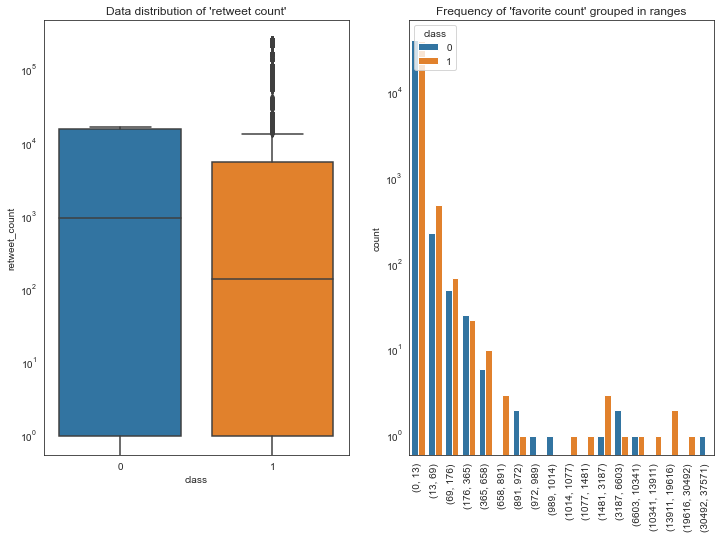

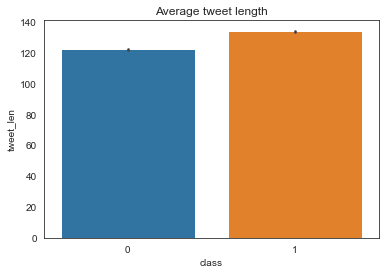

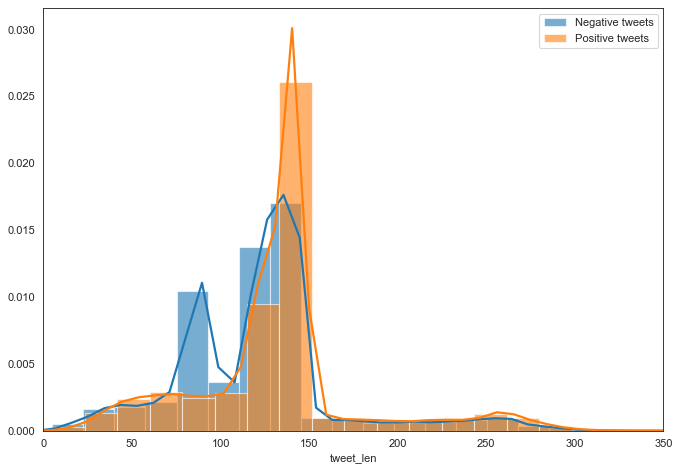

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
g = sns.boxplot('class', 'retweet_count', data=training_set, ax=axs[0])
g.set_yscale('log')
axs[0].set_title("Data distribution of 'retweet count'")

fav_count = training_set['favorite_count'].to_numpy().reshape(-1,1)

discretizer = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='kmeans')
X_binned = discretizer.fit_transform(fav_count)
X_binned = np.reshape(X_binned, len(X_binned))

ranges = []
for i in range(len(discretizer.bin_edges_[0]) - 1):
    item = (int(discretizer.bin_edges_[0][i]), int(discretizer.bin_edges_[0][i+1]))
    ranges.append(item)

g = sns.countplot(X_binned, hue='class', data=training_set, ax=axs[1])
g.set_yscale('log')
g.set_xticklabels(ranges, rotation=90)
axs[1].set_title("Frequency of 'favorite count' grouped in ranges")

plt.savefig(IMAGE_PATH + 'distribution')
plt.show()

ax = plt.subplot()
ax.set_title("Average tweet length")
sns.barplot('class', 'tweet_len', data=training_set)
plt.savefig(IMAGE_PATH + 'tweet_len')

x1 = training_set.loc[training_set['class'] == 1, 'tweet_len']
x2 = training_set.loc[training_set['class'] == 0, 'tweet_len']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, norm_hist=True)

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(x2, label="Negative tweets", **kwargs)
sns.distplot(x1, label="Positive tweets", **kwargs)

plt.xlim(0,350)
plt.legend()
plt.savefig(IMAGE_PATH + 'len_distrib')

In [52]:
tokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords, min_df=0.008)
X_tfidf = vectorizer.fit_transform(training_set['full_text'])

print(vectorizer.get_feature_names())

['#alllivesmatter',
 '#blackouttuesday',
 '#breonataylor',
 '#georgefloyd',
 '#opfancam',
 '@bluelivesmtr',
 '@crankgameplays',
 '@elijahdaniel',
 '@gianogionni',
 '@kthopkins',
 '@larryelder',
 '@mphillipyf',
 '@palmerreport',
 '@realdonaldtrump',
 '@variety',
 '@youranoncentral',
 'accidentally',
 'also',
 'america',
 'american',
 'anonymous',
 'anyone',
 'arse',
 'away',
 'back',
 'basis',
 'battle',
 'better',
 'black',
 'breonna',
 'bunker',
 'call',
 'cannot',
 'change',
 'city',
 'civil',
 'come',
 'community',
 'conquered',
 'country',
 'criminal',
 'damn',
 'death',
 'deman',
 'division',
 'donate',
 'drown',
 'even',
 'ever',
 'every',
 'everyone',
 'eyed',
 'family',
 'fancams',
 'farmer',
 'fight',
 'find',
 'first',
 'floyd',
 'follow',
 'forget',
 'friend',
 'george',
 'getting',
 'going',
 'good',
 'goodmorning',
 'group',
 'happy',
 'hashtag',
 'hell',
 'help',
 'hijacked',
 'home',
 'human',
 'justice',
 'k-pop',
 'keep',
 'killed',
 'killing',
 'know',
 'kpop',
 'larg

In [53]:
svd = TruncatedSVD(n_components=120, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.93


c:\users\david\pycharmprojects\data-science-lab\lab4\venv\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


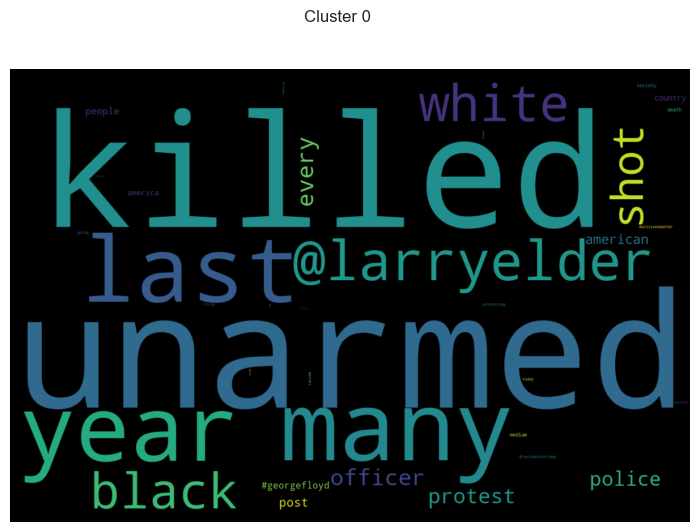

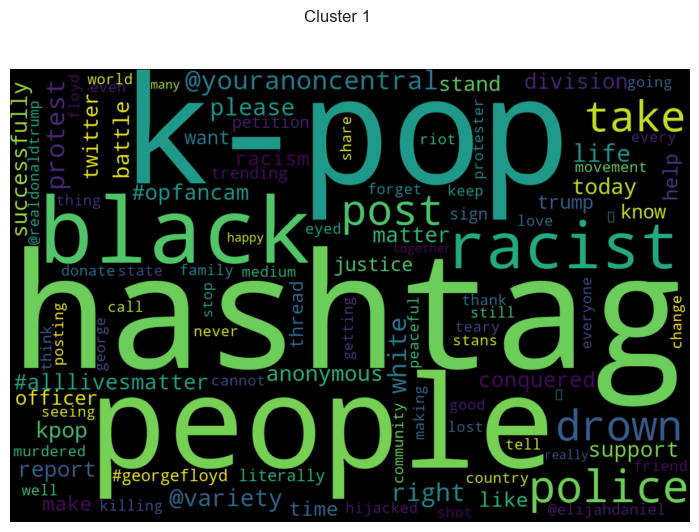

In [54]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)